In [127]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

### yfinance curntly do not work

In [150]:
stocks = []
for stock in ('IWM', 'NVDA', 'QQQ', 'SPY', 'TSLA'):
    file = f'day/{stock}.csv'
    df = pd.read_csv(file ,parse_dates=['Datetime'],
                    index_col='Datetime')
    df = df.set_index(pd.to_datetime(df.index, utc=True))
    stocks.append(df)
    
    
    

   day_of_week       IWM      NVDA       QQQ       SPY      TSLA
0            0 -0.019200  0.034328  0.110755  0.058405  0.372912
1            1 -0.026018  0.011635 -0.019099 -0.014084  0.005531
2            2 -0.042194 -0.001921 -0.018896  0.000086 -0.085734
3            3 -0.030252 -0.024804 -0.002353  0.006390 -0.251313
4            4 -0.000883 -0.021283 -0.026984  0.008927 -0.061772


C:\Users\shmue\AppData\Local\Temp\ipykernel_15064\1306907185.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_change = df.groupby('day_of_week').apply(lambda x: (x['Close'] - x['Open']).mean())
C:\Users\shmue\AppData\Local\Temp\ipykernel_15064\1306907185.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  day_change = df.groupby('day_of_week').apply(lambda x: (x['Close'] - x['Open']).mean())
C:\Users

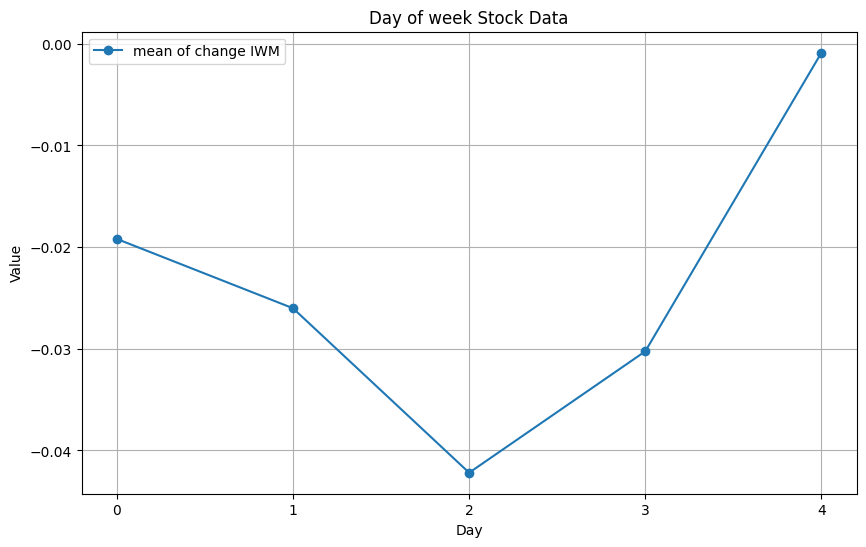

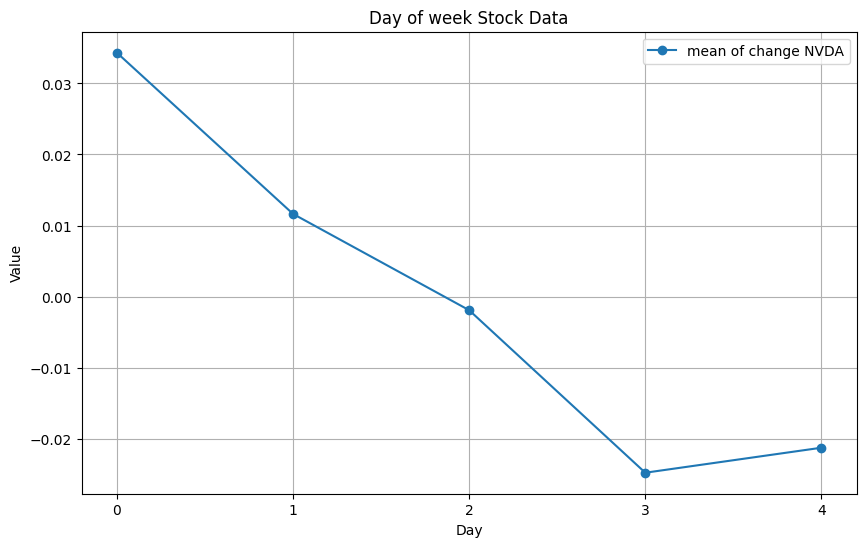

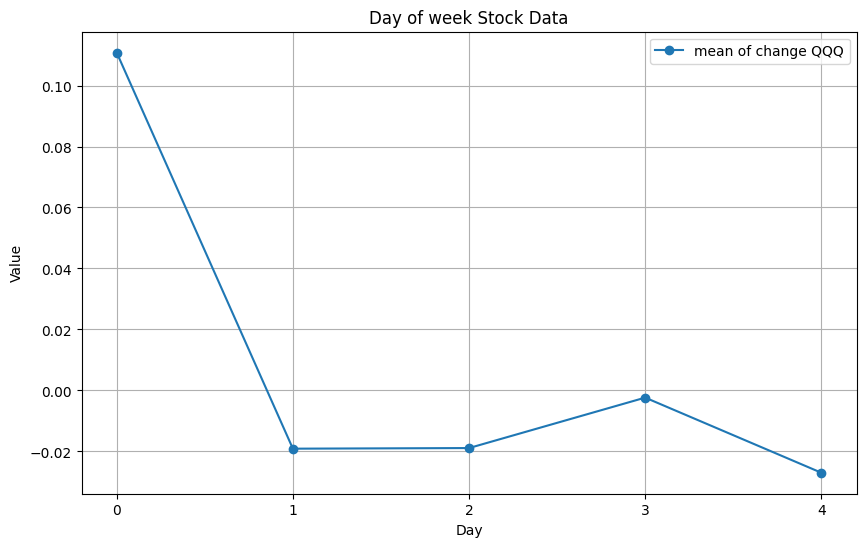

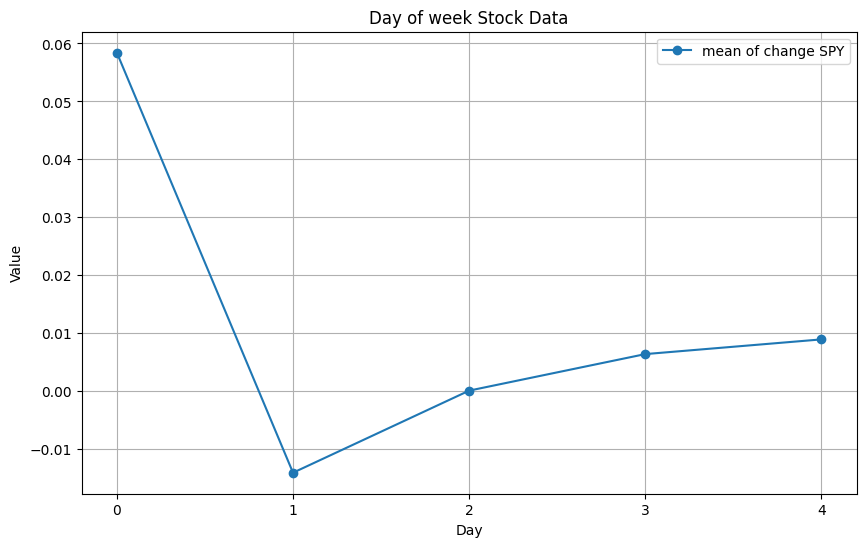

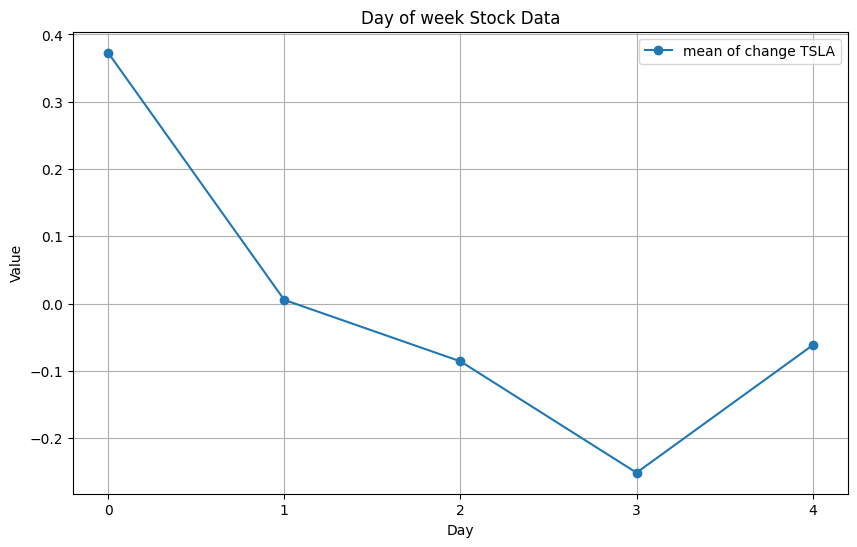

In [151]:
grouped_day = pd.DataFrame(columns=['day_of_week'])
for df, name in zip(stocks,('IWM', 'NVDA', 'QQQ', 'SPY', 'TSLA')):    
    df['day_of_week'] = df.index.dayofweek
    day_change = df.groupby('day_of_week').apply(lambda x: (x['Close'] - x['Open']).mean())
    # Create the plot
    # print()
    stock_df = day_change.to_frame() if isinstance(day_change, pd.Series) else day_change  # Ensure it's a DataFrame
    if not stock_df.empty:
        stock_df = stock_df.rename(columns={col: f"{name}" for col in stock_df.columns if col != "day_of_week"})  # Rename columns with stock name
        grouped_day =  grouped_day.merge(stock_df, on='day_of_week', how='outer')
    
print(grouped_day)
columns_to_plot = grouped_day.columns.difference(["day_of_week"])
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_day['day_of_week'], grouped_day[column], marker='o', linestyle='-', label=f'mean of change {column}')

    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.title("Day of week Stock Data")
    plt.legend()  # Show legend for multiple columns
    plt.grid(True)
    plt.xticks(grouped_day['day_of_week'])  # Ensure all hours are visible
    plt.show()



Day Name	.dt.dayofweek Value
Monday	0
Tuesday	1
Wednesday	2
Thursday	3
Friday	4
Saturday	5
Sunday	6